In [3]:
# Load necessary modules

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress as _linregress
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

In [4]:
# Functions 

def linregress(da_y, da_x, dim=None):
    '''xarray-wrapped function of scipy.stats.linregress.
    Note the order of the input arguments x, y is reversed to the original scipy function.'''
    if dim is None:
        dim = [d for d in da_y.dims if d in da_x.dims][0]
    slope, intercept, r, p, stderr = xr.apply_ufunc(_linregress, da_x, da_y,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[], [], [], [], []],
        vectorize=True,
        dask='allowed')
    predicted = da_x * slope + intercept
    slope.attrs['long_name'] = 'slope of the linear regression'
    intercept.attrs['long_name'] = 'intercept of the linear regression'
    r.attrs['long_name'] = 'correlation coefficient'
    p.attrs['long_name'] = 'p-value'
    stderr.attrs['long_name'] = 'standard error of the estimated gradient'
    predicted.attrs['long_name'] = 'predicted values by the linear regression model'
    return xr.Dataset(dict(slope=slope, intercept=intercept,
        r=r, p=p, stderr=stderr, predicted=predicted))

def area_weighted_ave(ds):
    if 'lat' not in ds.dims:
        ds = ds.rename({'latitude':'lat','longitude':'lon'})
    coslat = np.cos(np.deg2rad(ds.lat))
    ds,coslat = xr.broadcast(ds,coslat)
    ds = ds * coslat
    #return ds.mean(('lat','lon'),skipna=True)
    return ds.sum(('lat','lon'),skipna=True)/((ds/ds)*coslat).sum(('lat','lon'),skipna=True)

def draw_boxes(lon_min,lon_max,lat_min,lat_max):
    
    box_lon = [lon_min, lon_max, lon_max, lon_min, lon_min]
    box_lat = [lat_min, lat_min, lat_max, lat_max, lat_min]

    # Plot the box using plt.plot (on the same projection)
    ax.plot(box_lon, box_lat, color='k', linestyle='-', linewidth=2, zorder=20, transform=ccrs.PlateCarree())

def convert_longitude(ds):
    """
    Convert longitude from [0, 360] to [-180, 180].
    
    Parameters:
    - lon: array-like, input longitudes in the range [0, 360]
    
    Returns:
    - Converted longitudes in the range [-180, 180]
    """
    ds_new = ds.copy()
    lon = ds['longitude']  # Convert input to a NumPy array if it's not already
    converted_lon = (lon + 180) % 360 - 180  # Apply conversion
    ds_new.coords['longitude'] = converted_lon
    
    return ds_new.sortby('longitude')

right_side = -83
def get_ep(ds):
    ds_con = convert_longitude(ds)
    return area_weighted_ave(ds_con.sel(longitude=slice(-180,right_side),latitude=slice(-19,19)))

In [85]:
# Datasets
era5 = xr.open_dataset('/scratch/midway3/krucker01/ERA5/era5_t_pl_annual_1980_2024_regrid.nc').compute()
era5_land = xr.open_dataset('/scratch/midway3/krucker01/ERA5/era5_land_t_pl_annual_1980_2024_regrid.nc')
era5_ocean = xr.open_dataset('/scratch/midway3/krucker01/ERA5/era5_ocean_t_pl_annual_1980_2024_regrid.nc')


amip = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/AMIP/amip_annual_t_pl_1981_2024.nc').compute()
amip['latitude'] = era5['latitude']
amip['longitude'] = era5['longitude']
amip_land = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/AMIP/amip_land_annual_t_pl_1981_2024.nc')
amip_ocean = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/AMIP/amip_ocean_annual_t_pl_1981_2024.nc')


ace2 = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/ACE2_37/ace2_37_annual_t_interp_128x64.nc').T.compute()
ace2['latitude'] = era5['latitude']
ace2['longitude'] = era5['longitude']

ace2_land = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/ACE2_37/ace2_37_land_annual_t_interp_128x64.nc').T.compute()
ace2_ocean = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/ACE2_37/ace2_37_ocean_annual_t_interp_128x64.nc').T.compute()

ngcm = xr.open_dataset('/scratch/midway3/krucker01/ai-models/ngcm/climate_2.8_csp_pe/ngcm_annual_t_pl_1981_2023_csp.nc').compute()
ngcm['latitude'] = era5['latitude']
ngcm['longitude'] = era5['longitude']

ngcm_land = xr.open_dataset('/scratch/midway3/krucker01/ai-models/ngcm/climate_2.8_csp_pe/ngcm_land_annual_t_pl_1981_2023_csp.nc')
ngcm_ocean = xr.open_dataset('/scratch/midway3/krucker01/ai-models/ngcm/climate_2.8_csp_pe/ngcm_ocean_annual_t_pl_1981_2023_csp.nc')

In [6]:
amip = amip[['HadGEM3-GC31-LL_r1i1p1f3', 'MRI-ESM2-0_r1i1p1f1',
       'CanESM5_r1i1p2f1', 'CanESM5_r2i1p2f1', 'CanESM5_r3i1p2f1',
       'MIROC6_r1i1p1f1', 'CESM2']]

amip_land = amip_land[['HadGEM3-GC31-LL_r1i1p1f3', 'MRI-ESM2-0_r1i1p1f1',
       'CanESM5_r1i1p2f1', 'CanESM5_r2i1p2f1', 'CanESM5_r3i1p2f1',
       'MIROC6_r1i1p1f1', 'CESM2']]

amip_ocean = amip_ocean[['HadGEM3-GC31-LL_r1i1p1f3', 'MRI-ESM2-0_r1i1p1f1',
       'CanESM5_r1i1p2f1', 'CanESM5_r2i1p2f1', 'CanESM5_r3i1p2f1',
       'MIROC6_r1i1p1f1', 'CESM2']]

In [7]:
amip_pi = xr.open_dataset('/project/tas1/itbaxter/for-tiffany/amip-piForcing/180x360/ta/ta_allmem_annual_1980_2014_128x64.nc')
amip_pi['latitude'] = era5['latitude']
amip_pi['longitude'] = era5['longitude']
amip_pi

<xarray.Dataset> Size: 174MB
Dimensions:    (plev: 19, year: 35, member_id: 8, latitude: 64, longitude: 128)
Coordinates:
  * plev       (plev) float64 152B 1e+05 9.25e+04 8.5e+04 ... 1e+03 500.0 100.0
  * year       (year) int64 280B 1980 1981 1982 1983 ... 2011 2012 2013 2014
  * member_id  (member_id) <U24 768B 'HadGEM3-GC31-LL_r1i1p1f3' ... 'CESM2_r1...
  * latitude   (latitude) float64 512B -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
  * longitude  (longitude) float64 1kB 0.0 2.812 5.625 ... 351.6 354.4 357.2
    expver     int32 4B 1
Data variables:
    ta         (year, member_id, plev, latitude, longitude) float32 174MB ...

In [8]:
# Masks 
land_mask = xr.open_dataset('/scratch/midway3/krucker01/shp/ERA5_land_mask_64x128.nc').LSM
ocean_mask = xr.open_dataset('/scratch/midway3/krucker01/shp/ERA5_ocean_mask_64x128.nc').LSM

In [9]:
amip_land_pi = amip_pi.ta.where(ocean_mask==1)
amip_ocean_pi = amip_pi.ta.where(land_mask==1)

In [84]:
ace2_co2 = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/ace2_fixedCO2_t_plev_annual_128x64.nc').T.compute()
ace2_co2_land = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/ace2_fixedCO2_t_annual_plev_128x64_land.nc').T.compute()
ace2_co2_ocean = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/ace2_fixedCO2_t_annual_plev_128x64_ocean.nc').T.compute()

In [14]:
# Land sea mask from ERA5
land_sea_mask = xr.open_dataset('/scratch/midway3/krucker01/shp/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc')

#Regrid mask 1 degree
lat01 = land_sea_mask['latitude']
lon01 = land_sea_mask['longitude']

lat28 = era5['latitude']
lon28 = era5['longitude']

mask_era5_course = land_sea_mask['LSM'][0].interp(latitude=lat28, longitude=lon28)

land = xr.where(mask_era5_course, 1, np.nan)
ocean = xr.where(mask_era5_course, np.nan, 1)

In [16]:
# Geopotential Mask
mask_array = xr.open_dataset('/scratch/midway3/itbaxter/NeuralGCM_Decadal_Simulations/geopot_mask.nc')
mask = mask_array.__xarray_dataarray_variable__
mask = xr.where(mask, 1, np.nan)

In [70]:
title = '60S-20S'
lat1 = -60
lat2 = -20
year1 = '1981'
year2 = '2014'
min_percent = 0.05
max_percent = 0.95

In [18]:
title_other = '20S-20N'
lat1_other = -20
lat2_other = 20


In [71]:
# ERA5 trends

era5_tropics = area_weighted_ave(era5.t.sel(latitude=slice(lat1,lat2)).sel(year=slice(year1,year2))*mask.sel(level=era5.level))
era5_trend = (linregress(era5_tropics,era5_tropics.year).slope*10).values

era5_land_tropics = area_weighted_ave(era5_land.t.sel(latitude=slice(lat1,lat2)).sel(year=slice(year1,year2))*mask.sel(level=era5.level))
era5_land_trend = (linregress(era5_land_tropics,era5_land_tropics.year).slope*10).values

era5_ocean_tropics = area_weighted_ave(era5_ocean.t.sel(latitude=slice(lat1,lat2)).sel(year=slice(year1,year2))*mask.sel(level=era5.level))
era5_ocean_trend = (linregress(era5_ocean_tropics,era5_ocean_tropics.year).slope*10).values

In [22]:
# ERA5 trends

era5_tropics = area_weighted_ave(era5.t.sel(latitude=slice(lat1_other,lat2_other)).sel(year=slice(year1,year2))*mask.sel(level=era5.level))
era5_trend_other = (linregress(era5_tropics,era5_tropics.year).slope*10).values

era5_land_tropics = area_weighted_ave(era5_land.t.sel(latitude=slice(lat1_other,lat2_other)).sel(year=slice(year1,year2))*mask.sel(level=era5.level))
era5_land_trend_other = (linregress(era5_land_tropics,era5_land_tropics.year).slope*10).values

era5_ocean_tropics = area_weighted_ave(era5_ocean.t.sel(latitude=slice(lat1_other,lat2_other)).sel(year=slice(year1,year2))*mask.sel(level=era5.level))
era5_ocean_trend_other = (linregress(era5_ocean_tropics,era5_ocean_tropics.year).slope*10).values

In [72]:
# AMIP trends 

amip_tropics = area_weighted_ave(amip.sel(latitude = slice(lat1,lat2)).sel(year=slice(year1,year2))*mask.sel(level=amip.plev/100))
amip_tropics_array = amip_tropics.to_dataarray(dim='member_id')

amip_trend = (linregress(amip_tropics_array,amip_tropics_array.year).slope)*10

amip_trend_qts = np.nanquantile(amip_trend, [min_percent,max_percent], axis = 0)



amip_land_tropics = area_weighted_ave(amip_land.sel(latitude = slice(lat1,lat2)).sel(year=slice(year1,year2))*mask.sel(level=amip.plev/100))
amip_land_tropics_array = amip_land_tropics.to_dataarray(dim='member_id')

amip_land_trend = (linregress(amip_land_tropics_array,amip_land_tropics_array.year).slope)*10

amip_land_trend_qts = np.nanquantile(amip_land_trend, [min_percent,max_percent], axis = 0)



amip_ocean_tropics = area_weighted_ave(amip_ocean.sel(latitude = slice(lat1,lat2)).sel(year=slice(year1,year2))*mask.sel(level=amip.plev/100))
amip_ocean_tropics_array = amip_ocean_tropics.to_dataarray(dim='member_id')

amip_ocean_trend = (linregress(amip_ocean_tropics_array,amip_ocean_tropics_array.year).slope)*10

amip_ocean_trend_qts = np.nanquantile(amip_ocean_trend, [min_percent,max_percent], axis = 0)

In [24]:
# AMIP trends 

amip_tropics = area_weighted_ave(amip.sel(latitude = slice(lat1_other,lat2_other)).sel(year=slice(year1,year2))*mask.sel(level=amip.plev/100))
amip_tropics_array = amip_tropics.to_dataarray(dim='member_id')

amip_trend_other = (linregress(amip_tropics_array,amip_tropics_array.year).slope)*10

amip_trend_qts_other = np.nanquantile(amip_trend_other, [min_percent,max_percent], axis = 0)



amip_land_tropics = area_weighted_ave(amip_land.sel(latitude = slice(lat1_other,lat2_other)).sel(year=slice(year1,year2))*mask.sel(level=amip.plev/100))
amip_land_tropics_array = amip_land_tropics.to_dataarray(dim='member_id')

amip_land_trend_other = (linregress(amip_land_tropics_array,amip_land_tropics_array.year).slope)*10

amip_land_trend_qts_other = np.nanquantile(amip_land_trend_other, [min_percent,max_percent], axis = 0)



amip_ocean_tropics = area_weighted_ave(amip_ocean.sel(latitude = slice(lat1_other,lat2_other)).sel(year=slice(year1,year2))*mask.sel(level=amip.plev/100))
amip_ocean_tropics_array = amip_ocean_tropics.to_dataarray(dim='member_id')

amip_ocean_trend_other = (linregress(amip_ocean_tropics_array,amip_ocean_tropics_array.year).slope)*10

amip_ocean_trend_qts_other = np.nanquantile(amip_ocean_trend_other, [min_percent,max_percent], axis = 0)

In [73]:
# AMIP trends 

amip_tropics_pi = area_weighted_ave(amip_pi.ta.sel(latitude = slice(lat1,lat2)).sel(year=slice(year1,year2))*mask.sel(level=amip_pi.plev/100))
amip_tropics_array_pi = amip_tropics_pi

amip_trend_pi = (linregress(amip_tropics_array_pi,amip_tropics_array_pi.year).slope)*10

amip_trend_qts_pi = np.nanquantile(amip_trend_pi, [min_percent,max_percent], axis = 0)



amip_land_tropics_pi = area_weighted_ave(amip_land_pi.sel(latitude = slice(lat1,lat2)).sel(year=slice(year1,year2))*mask.sel(level=amip_pi.plev/100))
amip_land_tropics_array_pi = amip_land_tropics_pi

amip_land_trend_pi = (linregress(amip_land_tropics_array_pi,amip_land_tropics_array_pi.year).slope)*10

amip_land_trend_qts_pi = np.nanquantile(amip_land_trend_pi, [min_percent,max_percent], axis = 0)



amip_ocean_tropics_pi = area_weighted_ave(amip_ocean_pi.sel(latitude = slice(lat1,lat2)).sel(year=slice(year1,year2))*mask.sel(level=amip_pi.plev/100))
amip_ocean_tropics_array_pi = amip_ocean_tropics_pi

amip_ocean_trend_pi = (linregress(amip_ocean_tropics_array_pi,amip_ocean_tropics_array_pi.year).slope)*10

amip_ocean_trend_qts_pi = np.nanquantile(amip_ocean_trend_pi, [min_percent,max_percent], axis = 0)

In [26]:
# AMIP trends 

amip_tropics_pi = area_weighted_ave(amip_pi.ta.sel(latitude = slice(lat1_other,lat2_other)).sel(year=slice(year1,year2))*mask.sel(level=amip_pi.plev/100))
amip_tropics_array_pi = amip_tropics_pi

amip_trend_other_pi = (linregress(amip_tropics_array_pi,amip_tropics_array_pi.year).slope)*10

amip_trend_qts_other_pi = np.nanquantile(amip_trend_other_pi, [min_percent,max_percent], axis = 0)



amip_land_tropics_pi = area_weighted_ave(amip_land_pi.sel(latitude = slice(lat1_other,lat2_other)).sel(year=slice(year1,year2))*mask.sel(level=amip_pi.plev/100))
amip_land_tropics_array_pi = amip_land_tropics_pi

amip_land_trend_other_pi = (linregress(amip_land_tropics_array_pi,amip_land_tropics_array_pi.year).slope)*10

amip_land_trend_qts_other_pi = np.nanquantile(amip_land_trend_other_pi, [min_percent,max_percent], axis = 0)



amip_ocean_tropics_pi = area_weighted_ave(amip_ocean_pi.sel(latitude = slice(lat1_other,lat2_other)).sel(year=slice(year1,year2))*mask.sel(level=amip_pi.plev/100))
amip_ocean_tropics_array_pi = amip_ocean_tropics_pi

amip_ocean_trend_other_pi = (linregress(amip_ocean_tropics_array_pi,amip_ocean_tropics_array_pi.year).slope)*10

amip_ocean_trend_qts_other_pi = np.nanquantile(amip_ocean_trend_other_pi, [min_percent,max_percent], axis = 0)

In [74]:
# NGCM Trends 
ngcm_tropics = area_weighted_ave(ngcm.sel(latitude=slice(lat1,lat2)).sel(year=slice(year1,year2))*mask.sel(level=ngcm.level))
ngcm_tropics_array = ngcm_tropics.to_dataarray(dim = 'member_id')

ngcm_trend = (linregress(ngcm_tropics_array,ngcm_tropics_array['year']).slope*10).values

ngcm_trend_qts = np.quantile(ngcm_trend, [min_percent,max_percent], axis = 0)


ngcm_land_tropics = area_weighted_ave(ngcm_land.sel(latitude=slice(lat1,lat2)).sel(year=slice(year1,year2))*mask.sel(level=ngcm.level))
ngcm_land_tropics_array = ngcm_land_tropics.to_dataarray(dim = 'member_id')

ngcm_land_trend = (linregress(ngcm_land_tropics_array,ngcm_land_tropics_array['year']).slope*10).values

ngcm_land_trend_qts = np.quantile(ngcm_land_trend, [min_percent,max_percent], axis = 0)


ngcm_ocean_tropics = area_weighted_ave(ngcm_ocean.sel(latitude=slice(lat1,lat2)).sel(year=slice(year1,year2))*mask.sel(level=ngcm.level))
ngcm_ocean_tropics_array = ngcm_ocean_tropics.to_dataarray(dim = 'member_id')

ngcm_ocean_trend = (linregress(ngcm_ocean_tropics_array,ngcm_ocean_tropics_array['year']).slope*10).values

ngcm_ocean_trend_qts = np.quantile(ngcm_ocean_trend, [min_percent,max_percent], axis = 0)

In [29]:
# NGCM Trends 
ngcm_tropics = area_weighted_ave(ngcm.sel(latitude=slice(lat1_other,lat2_other)).sel(year=slice(year1,year2))*mask.sel(level=ngcm.level))
ngcm_tropics_array = ngcm_tropics.to_dataarray(dim = 'member_id')

ngcm_trend_other = (linregress(ngcm_tropics_array,ngcm_tropics_array['year']).slope*10).values

ngcm_trend_qts_other = np.quantile(ngcm_trend_other, [min_percent,max_percent], axis = 0)


ngcm_land_tropics = area_weighted_ave(ngcm_land.sel(latitude=slice(lat1_other,lat2_other)).sel(year=slice(year1,year2))*mask.sel(level=ngcm.level))
ngcm_land_tropics_array = ngcm_land_tropics.to_dataarray(dim = 'member_id')

ngcm_land_trend_other = (linregress(ngcm_land_tropics_array,ngcm_land_tropics_array['year']).slope*10).values

ngcm_land_trend_qts_other = np.quantile(ngcm_land_trend_other, [min_percent,max_percent], axis = 0)


ngcm_ocean_tropics = area_weighted_ave(ngcm_ocean.sel(latitude=slice(lat1_other,lat2_other)).sel(year=slice(year1,year2))*mask.sel(level=ngcm.level))
ngcm_ocean_tropics_array = ngcm_ocean_tropics.to_dataarray(dim = 'member_id')

ngcm_ocean_trend_other = (linregress(ngcm_ocean_tropics_array,ngcm_ocean_tropics_array['year']).slope*10).values

ngcm_ocean_trend_qts_other = np.quantile(ngcm_ocean_trend_other, [min_percent,max_percent], axis = 0)

In [86]:
# ACE2 Trends
ace2_tropics = area_weighted_ave(ace2.sel(latitude=slice(lat1,lat2)).sel(year=slice(year1,year2))*mask.sel(level=ace2.level))
ace2_trend = (linregress(ace2_tropics,ace2_tropics['year']).slope*10).values
ace2_trend_qts = np.nanquantile(ace2_trend, [min_percent,max_percent], axis = 0)


ace2_land_tropics = area_weighted_ave(ace2_land.sel(latitude=slice(lat1,lat2)).sel(year=slice(year1,year2))*mask.sel(level=ace2.level))
ace2_land_trend = (linregress(ace2_land_tropics,ace2_land_tropics['year']).slope*10).values
ace2_land_trend_qts = np.nanquantile(ace2_land_trend, [min_percent,max_percent], axis = 0)


ace2_ocean_tropics = area_weighted_ave(ace2_ocean.sel(latitude=slice(lat1,lat2)).sel(year=slice(year1,year2))*mask.sel(level=ace2.level))
ace2_ocean_trend = (linregress(ace2_ocean_tropics,ace2_ocean_tropics['year']).slope*10).values
ace2_ocean_trend_qts = np.nanquantile(ace2_ocean_trend, [min_percent,max_percent], axis = 0)

In [32]:
# ACE2 Trends
ace2_tropics = area_weighted_ave(ace2.sel(latitude=slice(lat1_other,lat2_other)).sel(year=slice(year1,year2))*mask.sel(level=ace2.level))
ace2_trend_other = (linregress(ace2_tropics,ace2_tropics['year']).slope*10).values
ace2_trend_qts_other = np.nanquantile(ace2_trend_other, [min_percent,max_percent], axis = 0)


ace2_land_tropics = area_weighted_ave(ace2_land.sel(latitude=slice(lat1_other,lat2_other)).sel(year=slice(year1,year2))*mask.sel(level=ace2.level))
ace2_land_trend_other = (linregress(ace2_land_tropics,ace2_land_tropics['year']).slope*10).values
ace2_land_trend_qts_other = np.nanquantile(ace2_land_trend_other, [min_percent,max_percent], axis = 0)


ace2_ocean_tropics = area_weighted_ave(ace2_ocean.sel(latitude=slice(lat1_other,lat2_other)).sel(year=slice(year1,year2))*mask.sel(level=ace2.level))
ace2_ocean_trend_other = (linregress(ace2_ocean_tropics,ace2_ocean_tropics['year']).slope*10).values
ace2_ocean_trend_qts_other = np.nanquantile(ace2_ocean_trend_other, [min_percent,max_percent], axis = 0)

In [87]:
# ACE2 Co2 Trends
ace2_co2_tropics = area_weighted_ave(ace2_co2.sel(latitude=slice(lat1,lat2)).sel(year=slice(year1,year2))*mask.sel(level=ace2_co2.level))
ace2_co2_trend = (linregress(ace2_co2_tropics,ace2_co2_tropics['year']).slope*10).values
ace2_co2_trend_qts = np.nanquantile(ace2_co2_trend, [min_percent,max_percent], axis = 0)


ace2_co2_land_tropics = area_weighted_ave(ace2_co2_land.sel(latitude=slice(lat1,lat2)).sel(year=slice(year1,year2))*mask.sel(level=ace2_co2.level))
ace2_co2_land_trend = (linregress(ace2_co2_land_tropics,ace2_co2_land_tropics['year']).slope*10).values
ace2_co2_land_trend_qts = np.nanquantile(ace2_co2_land_trend, [min_percent,max_percent], axis = 0)


ace2_co2_ocean_tropics = area_weighted_ave(ace2_co2_ocean.sel(latitude=slice(lat1,lat2)).sel(year=slice(year1,year2))*mask.sel(level=ace2_co2.level))
ace2_co2_ocean_trend = (linregress(ace2_co2_ocean_tropics,ace2_ocean_tropics['year']).slope*10).values
ace2_co2_ocean_trend_qts = np.nanquantile(ace2_co2_ocean_trend, [min_percent,max_percent], axis = 0)

In [34]:
# ACE2 Co2 Trends
ace2_co2_tropics = area_weighted_ave(ace2_co2.sel(latitude=slice(lat1_other,lat2_other)).sel(year=slice(year1,year2))*mask.sel(level=ace2_co2.level))
ace2_co2_trend_other = (linregress(ace2_co2_tropics,ace2_co2_tropics['year']).slope*10).values
ace2_co2_trend_qts_other = np.nanquantile(ace2_co2_trend_other, [min_percent,max_percent], axis = 0)


ace2_co2_land_tropics = area_weighted_ave(ace2_co2_land.sel(latitude=slice(lat1_other,lat2_other)).sel(year=slice(year1,year2))*mask.sel(level=ace2_co2.level))
ace2_co2_land_trend_other = (linregress(ace2_co2_land_tropics,ace2_co2_land_tropics['year']).slope*10).values
ace2_co2_land_trend_qts_other = np.nanquantile(ace2_co2_land_trend_other, [min_percent,max_percent], axis = 0)


ace2_co2_ocean_tropics = area_weighted_ave(ace2_co2_ocean.sel(latitude=slice(lat1_other,lat2_other)).sel(year=slice(year1,year2))*mask.sel(level=ace2_co2.level))
ace2_co2_ocean_trend_other = (linregress(ace2_co2_ocean_tropics,ace2_co2_ocean_tropics['year']).slope*10).values
ace2_co2_ocean_trend_qts_other = np.nanquantile(ace2_co2_ocean_trend_other, [min_percent,max_percent], axis = 0)

### 250-hPa Time Series 

In [77]:
# Select T250hPa
era5_250 = era5.sel(level = 250)

amip_250 = amip.sel(plev = 25000)

ace2_250 = ace2.sel(level = 250)

ace2_250_co2 = ace2_co2.sel(level = 250)

ngcm_250 = ngcm.sel(level = 250)

In [78]:
# Calculate time series 

# ERA5
era5_time = area_weighted_ave(era5_250.sel(latitude = slice(lat1,lat2))).sel(year=slice(1981,2022))
era5_norm = era5_time - (era5_time.sel(year=slice(1981,1990)).mean().t)

# AMIP
amip_1 = amip_250.to_dataarray().sel(latitude = slice(lat1,lat2))
amip_time = area_weighted_ave(amip_1)
amip_norm = amip_time-(amip_time.sel(year=slice(1981,1990)).mean())

# ACE2
ace2_time = area_weighted_ave(ace2_250.sel(latitude = slice(lat1,lat2))).sel(year=slice(1981,2021))
ace2_norm = ace2_time-(ace2_time.sel(year=slice(1981,1990)).mean())

# ACE2
ace2_time_co2 = area_weighted_ave(ace2_250_co2.sel(latitude = slice(lat1,lat2))).sel(year=slice(1981,2021))
ace2_norm_co2 = ace2_time_co2-(ace2_time_co2.sel(year=slice(1981,1990)).mean())

# NGCM
ngcm_time = area_weighted_ave(ngcm_250.to_dataarray().sel(latitude = slice(lat1,lat2))).sel(year=slice(1981,2022))
ngcm_norm = ngcm_time-(ngcm_time.sel(year=slice(1981,1990)).mean())

In [41]:
# Calculate time series 

# ERA5
era5_time = area_weighted_ave(era5_250.sel(latitude = slice(lat1_other,lat2_other))).sel(year=slice(1981,2022))
era5_norm_other = era5_time - (era5_time.sel(year=slice(1981,1990)).mean().t)

# AMIP
amip_1 = amip_250.to_dataarray().sel(latitude = slice(lat1_other,lat2_other))
amip_time = area_weighted_ave(amip_1)
amip_norm_other = amip_time-(amip_time.sel(year=slice(1981,1990)).mean())

# ACE2
ace2_time = area_weighted_ave(ace2_250.sel(latitude = slice(lat1_other,lat2_other))).sel(year=slice(1981,2021))
ace2_norm_other = ace2_time-(ace2_time.sel(year=slice(1981,1990)).mean())

# NGCM
ngcm_time = area_weighted_ave(ngcm_250.to_dataarray().sel(latitude = slice(lat1_other,lat2_other))).sel(year=slice(1981,2022))
ngcm_norm_other = ngcm_time-(ngcm_time.sel(year=slice(1981,1990)).mean())

In [79]:
# Select T900hPa
era5_900 = era5.sel(level = 925)

amip_900 = amip.sel(plev = 92500)

ace2_900 = ace2.sel(level = 925)

ace2_900_co2 = ace2_co2.sel(level = 925)

ngcm_900 = ngcm.sel(level = 925)

In [80]:
# ERA5
era5_time_900 = area_weighted_ave(era5_900.sel(latitude = slice(lat1,lat2)))
era5_norm_900 = era5_time_900 - (era5_time_900.sel(year=slice(1980,1990)).mean().t)

# AMIP
amip_1_900 = amip_900.to_dataarray().mean('variable').sel(latitude = slice(lat1,lat2))
amip_time_900 = area_weighted_ave(amip_1_900)
amip_norm_900 = amip_time_900-(amip_time_900.sel(year=slice(1980,1990)).mean())

# ACE2
ace2_time_900 = area_weighted_ave(ace2_900.mean('member_id').sel(latitude = slice(lat1,lat2))).sel(year=slice(1979,2021))
ace2_norm_900 = ace2_time_900-(ace2_time_900.sel(year=slice(1980,1990)).mean())

ace2_time_900_co2 = area_weighted_ave(ace2_900_co2.mean('member_id').sel(latitude = slice(lat1,lat2))).sel(year=slice(1979,2021))
ace2_norm_900_co2 = ace2_time_900_co2-(ace2_time_900_co2.sel(year=slice(1980,1990)).mean())

# NGCM
ngcm_time_900 = area_weighted_ave(ngcm_900.to_dataarray().mean('variable').sel(latitude = slice(lat1,lat2)))
ngcm_norm_900 = ngcm_time_900-(ngcm_time_900.sel(year=slice(1980,1990)).mean())

In [44]:
# ERA5
era5_time_900 = area_weighted_ave(era5_900.sel(latitude = slice(lat1_other,lat2_other)))
era5_norm_900_other = era5_time_900 - (era5_time_900.sel(year=slice(1980,1990)).mean().t)

# AMIP
amip_1_900 = amip_900.to_dataarray().mean('variable').sel(latitude = slice(lat1_other,lat2_other))
amip_time_900 = area_weighted_ave(amip_1_900)
amip_norm_900_other = amip_time_900-(amip_time_900.sel(year=slice(1980,1990)).mean())

# ACE2
ace2_time_900 = area_weighted_ave(ace2_900.mean('member_id').sel(latitude = slice(lat1_other,lat2_other))).sel(year=slice(1979,2021))
ace2_norm_900_other = ace2_time_900-(ace2_time_900.sel(year=slice(1980,1990)).mean())

# NGCM
ngcm_time_900 = area_weighted_ave(ngcm_900.to_dataarray().mean('variable').sel(latitude = slice(lat1_other,lat2_other)))
ngcm_norm_900_other = ngcm_time_900-(ngcm_time_900.sel(year=slice(1980,1990)).mean())

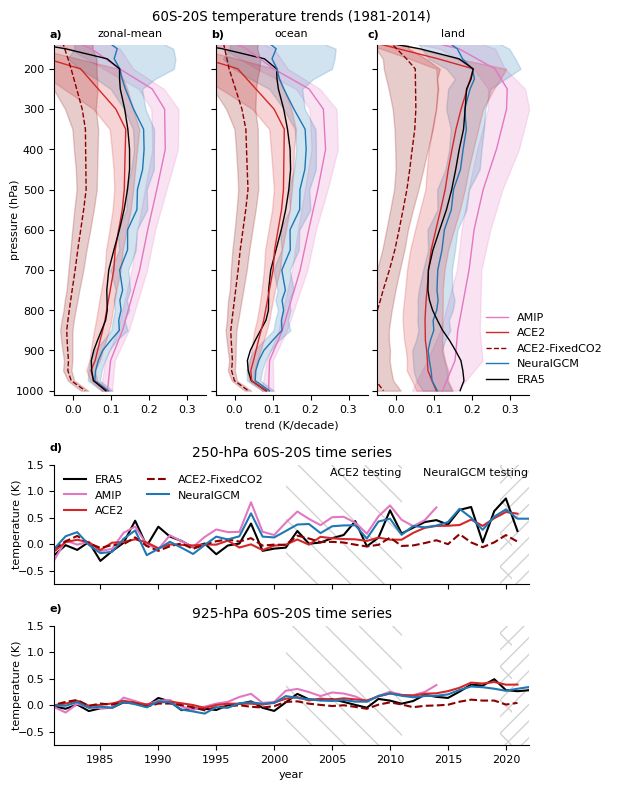

In [95]:
# Plotting
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
font = 8
c_choice = 'magenta'
line = 1
plt.rc('font', size=font)
fig = plt.figure(figsize=(4.75,  7))#, layout = 'constrained')
plt.axis('off')
plt.suptitle(title+' temperature trends ('+year1+'-'+year2+')', y=1.05)
plt.rcParams['hatch.color'] = 'lightgray'
fig_length = 0.5
fig_bot = 0.5

fig.text(-0.01,1.01, 'a)', weight = 'bold', fontsize = font)
fig.text(0.33,1.01, 'b)', weight = 'bold', fontsize = font)
fig.text(0.66,1.01, 'c)', weight = 'bold', fontsize = font)
fig.text(-0.01,0.42, 'd)', weight = 'bold', fontsize = font)
fig.text(-0.01,0.19, 'e)', weight = 'bold', fontsize = font)


ax = fig.add_axes([0,fig_bot,0.32,fig_length])
ax.set_rasterized(True)

ax.plot(np.nanmean(amip_trend, axis = 0), amip.plev/100, color='#E377C2', linewidth=line)
#ax.plot(np.nanmean(amip_trend_pi, axis = 0), amip_pi.plev/100, color=c_choice, linewidth=line, linestyle = '--')

ax.plot(np.nanmean(ace2_trend,axis=0), ace2.level, color='#D62728', linewidth=line)
ax.plot(np.nanmean(ace2_co2_trend,axis=0), ace2.level, color='darkred', linewidth=line, linestyle = '--')


ax.plot(ngcm_trend.mean(0), ngcm.level, color='#1F77B4', linewidth=line)

ax.plot(era5_trend, era5.level, color='k', linewidth=line)
ax.fill_betweenx(amip.plev/100, amip_trend_qts[0], amip_trend_qts[1], color = '#E377C2', alpha = 0.2)
#ax.fill_betweenx(amip_pi.plev/100, amip_trend_qts_pi[0], amip_trend_qts_pi[1], color = c_choice, alpha = 0.2)

ax.fill_betweenx(ngcm.level, ngcm_trend_qts[0], ngcm_trend_qts[1], color = '#1F77B4', alpha = 0.2)

ax.fill_betweenx(ace2.level, ace2_trend_qts[0], ace2_trend_qts[1], color = '#D62728', alpha = 0.2)
ax.fill_betweenx(ace2.level, ace2_co2_trend_qts[0], ace2_co2_trend_qts[1], color = 'darkred', alpha = 0.2)



ax.yaxis.set_inverted(True)
ax.set_ylim(1010, 140)
ax.set_yticks(np.arange(1000,199,-100))
ax.set_xlim(-0.005*10, 0.035*10)
ax.set_xticks([0,0.01*10,0.02*10,0.3])
ax.tick_params(axis = 'both', labelsize = font)

ax.set_ylabel('pressure (hPa)',fontsize=font, labelpad = -3)
ax.set_title("zonal-mean", fontsize = font)

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

ax = fig.add_axes([0.34,fig_bot,0.32,fig_length])
ax.set_rasterized(True)
ax.plot(era5_ocean_trend, era5_ocean.level, color='k', linewidth=line)
ax.plot(np.nanmean(amip_ocean_trend, axis = 0), amip_ocean.plev/100, color='#E377C2', linewidth=line)
#ax.plot(np.nanmean(amip_ocean_trend_pi, axis = 0), amip_ocean_pi.plev/100, color=c_choice, linewidth=line, linestyle = '--')

ax.plot(np.nanmean(ace2_ocean_trend,axis=0), ace2.level, color='#D62728', linewidth=line)
ax.plot(np.nanmean(ace2_co2_ocean_trend,axis=0), ace2.level, color='darkred', linewidth=line, linestyle = '--')


ax.plot(ngcm_ocean_trend.mean(0), ngcm_ocean.level, color='#1F77B4', linewidth=line)

#ax.fill_betweenx(amip_ocean_pi.plev/100, amip_ocean_trend_qts_pi[0], amip_ocean_trend_qts_pi[1], color = c_choice, alpha = 0.2)

ax.fill_betweenx(amip_ocean.plev/100, amip_ocean_trend_qts[0], amip_ocean_trend_qts[1], color = '#E377C2', alpha = 0.2)
ax.fill_betweenx(ngcm_ocean.level, ngcm_ocean_trend_qts[0], ngcm_ocean_trend_qts[1], color = '#1F77B4', alpha = 0.2)

ax.fill_betweenx(ace2_ocean.level, ace2_ocean_trend_qts[0], ace2_ocean_trend_qts[1], color = '#D62728', alpha = 0.2)
ax.fill_betweenx(ace2_ocean.level, ace2_co2_ocean_trend_qts[0], ace2_co2_ocean_trend_qts[1], color = 'darkred', alpha = 0.2)



ax.yaxis.set_inverted(True)
ax.set_ylim(1010, 140)
ax.set_yticklabels([])
ax.set_xlim(-0.005*10, 0.035*10)
ax.set_xticks([0,0.01*10,0.02*10,0.3])
ax.tick_params(axis = 'x', labelsize = font)

ax.set_xlabel('trend (K/decade)',fontsize=font)
ax.set_title("ocean", fontsize = font)

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

ax = fig.add_axes([0.68,fig_bot,0.32,fig_length])
ax.set_rasterized(True)
#ax.plot(np.nanmean(amip_land_trend_pi, axis = 0), amip_land_pi.plev/100, color=c_choice, linewidth=line, linestyle = '--')
ax.plot(np.nanmean(amip_land_trend, axis = 0), amip_land.plev/100, color='#E377C2', linewidth=line)
ax.plot(np.nanmean(ace2_land_trend,axis=0), ace2.level, color='#D62728', linewidth=line)
ax.plot(np.nanmean(ace2_co2_land_trend,axis=0), ace2.level, color='darkred', linewidth=line, linestyle = '--')


ax.plot(ngcm_land_trend.mean(0), ngcm_land.level, color='#1F77B4', linewidth=line)

ax.plot(era5_land_trend, era5_land.level, color='k', linewidth=line)
ax.fill_betweenx(amip_ocean.plev/100, amip_land_trend_qts[0], amip_land_trend_qts[1], color = '#E377C2', alpha = 0.2)
#ax.fill_betweenx(amip_ocean_pi.plev/100, amip_land_trend_qts_pi[0], amip_land_trend_qts_pi[1], color = c_choice, alpha = 0.2)

ax.fill_betweenx(ngcm_land.level, ngcm_land_trend_qts[0], ngcm_land_trend_qts[1], color ='#1F77B4', alpha = 0.2)

ax.fill_betweenx(ace2_land.level, ace2_land_trend_qts[0], ace2_land_trend_qts[1], color = '#D62728', alpha = 0.2)
ax.fill_betweenx(ace2_land.level, ace2_co2_land_trend_qts[0], ace2_co2_land_trend_qts[1], color = 'darkred', alpha = 0.2)


plt.legend(['AMIP', 'ACE2', 'ACE2-FixedCO2', 'NeuralGCM', 'ERA5'], loc = 'lower right', frameon = False, fontsize = font, bbox_to_anchor = (1.55, 0))

ax.yaxis.set_inverted(True)
ax.set_ylim(1010, 140)
ax.set_yticklabels([])
ax.set_xlim(-0.005*10, 0.035*10)
ax.set_xticks([0,0.01*10,0.02*10,0.3])
ax.tick_params(axis = 'x', labelsize = font)

ax.set_title("land", fontsize = font)

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

ax = fig.add_axes([0,0.23,1,0.17])
ax.plot(era5_norm.year[:-1], era5_norm.t[:-1], color = 'k', label = 'ERA5')
ax.plot(amip_norm.year, amip_norm.mean('variable'), color = '#E377C2', label = 'AMIP')
ax.plot(ace2_norm.year, ace2_norm.mean('member_id'), color = '#D62728', label = 'ACE2')
ax.plot(ace2_norm_co2.year, ace2_norm_co2.mean('member_id'), color = 'darkred', label = 'ACE2-FixedCO2', linestyle = '--')

ax.plot(ngcm_norm.year, ngcm_norm.mean('variable'), color = '#1F77B4', label = 'NeuralGCM')

plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')
ax.text(2011,1.45, 'ACE2 testing', ha = 'right', va = 'top', fontsize = font)
ax.text(2021.9,1.45, 'NeuralGCM testing', ha = 'right', va = 'top', fontsize = font)


ax.set_xlim([1981,2022])
ax.set_xticks([1985,1990,1995,2000,2005,2010,2015,2020])
ax.set_xticklabels([])
ax.set_ylim([-0.75,1.5])
ax.set_yticks([-0.5,0,0.5,1.0,1.5])
ax.set_title(f'250-hPa {title} time series', fontsize = font+2)
ax.set_ylabel('temperature (K)',fontsize=font, labelpad= -3)
ax.tick_params(axis = 'both', labelsize = font)
plt.legend(bbox_to_anchor = None, loc = 'upper left', frameon=False, ncol = 2, fontsize = font)

ax = fig.add_axes([0,0,1,0.17])
ax.plot(era5_norm_900.year[:-1], era5_norm_900.t[:-1], color = 'k', label = 'ERA5')
ax.plot(amip_norm_900.year, amip_norm_900, color = '#E377C2', label = 'AMIP')
ax.plot(ace2_norm_900.year, ace2_norm_900, color = '#D62728', label = 'ACE2')
ax.plot(ace2_norm_900_co2.year, ace2_norm_900_co2, color = 'darkred', label = 'ACE2-FixedCO2', linestyle = '--')

ax.plot(ngcm_norm_900.year, ngcm_norm_900, color = '#1F77B4', label = 'NeuralGCM')

plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')

ax.set_xlim([1981,2022])
ax.set_xticks([1985,1990,1995,2000,2005,2010,2015,2020])
ax.set_ylim([-0.75,1.5])
ax.set_yticks([-0.5,0,0.5,1.0,1.5])
ax.set_title(f'925-hPa {title} time series', fontsize = font+2)
ax.set_xlabel('year',fontsize=font)
ax.set_ylabel('temperature (K)',fontsize=font, labelpad= -3)
ax.tick_params(axis = 'both', labelsize = font)


plt.savefig('Thermo_Fig_2_'+title+'_FixedCO2.pdf', dpi = 550, bbox_inches='tight', )
plt.savefig('Thermo_Fig_2_'+title+'_FixedCO2.eps', dpi = 550, bbox_inches='tight', )

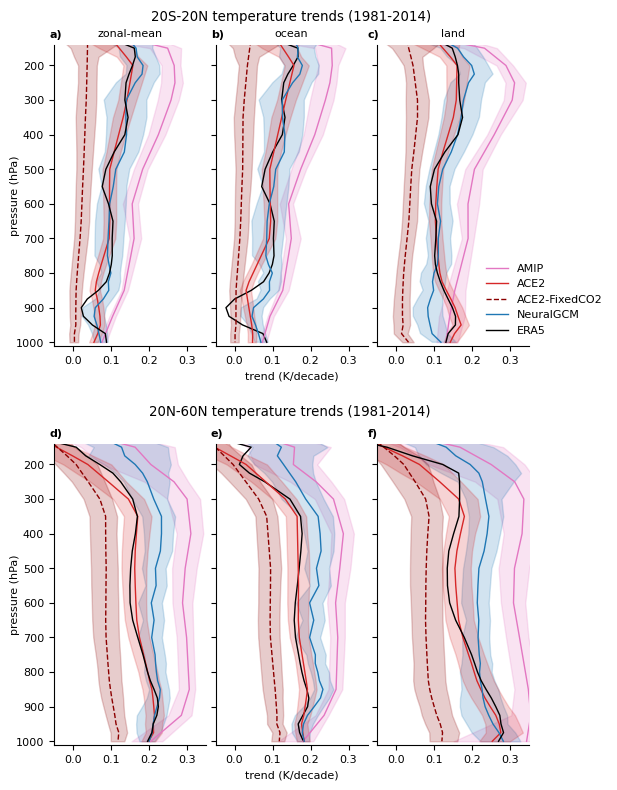

In [62]:
# Plotting
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
font = 8
line = 1
plt.rc('font', size=font)
fig = plt.figure(figsize=(4.75,  7))#, layout = 'constrained')
plt.axis('off')
plt.suptitle(title_other+' temperature trends ('+year1+'-'+year2+')', y=1.05)
#plt.suptitle(title+' temperature trends ('+year1+'-'+year2+')', y=0.48)
plt.rcParams['hatch.color'] = 'lightgray'
fig_length = 0.43
fig_bot = 0.57

c_choice = 'magenta'

fig.text(0.2, 0.47, title+' temperature trends ('+year1+'-'+year2+')', fontsize = 'large')
fig.text(-0.01,1.01, 'a)', weight = 'bold', fontsize = font)
fig.text(0.33,1.01, 'b)', weight = 'bold', fontsize = font)
fig.text(0.66,1.01, 'c)', weight = 'bold', fontsize = font)
fig.text(-0.01,0.44, 'd)', weight = 'bold', fontsize = font)
fig.text(0.33,0.44, 'e)', weight = 'bold', fontsize = font)
fig.text(0.66,0.44, 'f)', weight = 'bold', fontsize = font)

####
ax = fig.add_axes([0,fig_bot,0.32,fig_length])
ax.set_rasterized(True)
ax.plot(np.nanmean(amip_trend_other, axis = 0), amip.plev/100, color='#E377C2', linewidth=line)
#ax.plot(np.nanmean(amip_trend_other_pi, axis = 0), amip_pi.plev/100, color=c_choice, linewidth=line, linestyle = '--')
ax.plot(np.nanmean(ace2_trend_other,axis=0), ace2.level, color='#D62728', linewidth=line)
ax.plot(np.nanmean(ace2_co2_trend_other,axis=0), ace2.level, color='darkred', linewidth=line, linestyle = '--')


ax.plot(ngcm_trend_other.mean(0), ngcm.level, color='#1F77B4', linewidth=line)

ax.plot(era5_trend_other, era5.level, color='k', linewidth=line)
ax.fill_betweenx(amip.plev/100, amip_trend_qts_other[0], amip_trend_qts_other[1], color = '#E377C2', alpha = 0.2)
#ax.fill_betweenx(amip.plev/100, amip_trend_qts_other_pi[0], amip_trend_qts_other_pi[1], color = c_choice, alpha = 0.2)
ax.fill_betweenx(ngcm.level, ngcm_trend_qts_other[0], ngcm_trend_qts_other[1], color = '#1F77B4', alpha = 0.2)
ax.fill_betweenx(ace2.level, ace2_trend_qts_other[0], ace2_trend_qts_other[1], color = '#D62728', alpha = 0.2)
ax.fill_betweenx(ace2.level, ace2_co2_trend_qts_other[0], ace2_co2_trend_qts_other[1], color = 'darkred', alpha = 0.2)



ax.yaxis.set_inverted(True)
ax.set_ylim(1010, 140)
ax.set_yticks(np.arange(1000,199,-100))
ax.set_xlim(-0.005*10, 0.035*10)
ax.set_xticks([0,0.01*10,0.02*10,0.3])
ax.tick_params(axis = 'both', labelsize = font)

ax.set_ylabel('pressure (hPa)',fontsize=font, labelpad = -3)
ax.set_title("zonal-mean", fontsize = font)

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False


####
ax = fig.add_axes([0.34,fig_bot,0.32,fig_length])
ax.set_rasterized(True)
ax.plot(era5_ocean_trend_other, era5_ocean.level, color='k', linewidth=line)
ax.plot(np.nanmean(amip_ocean_trend_other, axis = 0), amip_ocean.plev/100, color='#E377C2', linewidth=line)
#ax.plot(np.nanmean(amip_ocean_trend_other_pi, axis = 0), amip_ocean_pi.plev/100, color=c_choice, linewidth=line, linestyle = '--')
ax.plot(np.nanmean(ace2_ocean_trend_other,axis=0), ace2.level, color='#D62728', linewidth=line)
ax.plot(np.nanmean(ace2_co2_ocean_trend_other,axis=0), ace2.level, color='darkred', linewidth=line, linestyle = '--')


ax.plot(ngcm_ocean_trend_other.mean(0), ngcm_ocean.level, color='#1F77B4', linewidth=line)

ax.fill_betweenx(amip_ocean.plev/100, amip_ocean_trend_qts_other[0], amip_ocean_trend_qts_other[1], color = '#E377C2', alpha = 0.2)
#ax.fill_betweenx(amip_ocean_pi.plev/100, amip_ocean_trend_qts_other_pi[0], amip_ocean_trend_qts_other_pi[1], color = c_choice, alpha = 0.2)

ax.fill_betweenx(ngcm_ocean.level, ngcm_ocean_trend_qts_other[0], ngcm_ocean_trend_qts_other[1], color = '#1F77B4', alpha = 0.2)

ax.fill_betweenx(ace2_ocean.level, ace2_ocean_trend_qts_other[0], ace2_ocean_trend_qts_other[1], color = '#D62728', alpha = 0.2)
ax.fill_betweenx(ace2_co2_ocean.level, ace2_co2_ocean_trend_qts_other[0], ace2_co2_ocean_trend_qts_other[1], color = 'darkred', alpha = 0.2)



ax.yaxis.set_inverted(True)
ax.set_ylim(1010, 140)
ax.set_yticklabels([])
ax.set_xlim(-0.005*10, 0.035*10)
ax.set_xticks([0,0.01*10,0.02*10,0.3])
ax.tick_params(axis = 'x', labelsize = font)

ax.set_xlabel('trend (K/decade)',fontsize=font)
ax.set_title("ocean", fontsize = font)

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False


####
ax = fig.add_axes([0.68,fig_bot,0.32,fig_length])
ax.set_rasterized(True)
ax.plot(np.nanmean(amip_land_trend_other, axis = 0), amip_land.plev/100, color='#E377C2', linewidth=line)
#ax.plot(np.nanmean(amip_land_trend_other_pi, axis = 0), amip_land_pi.plev/100, color=c_choice, linewidth=line, linestyle = '--')

ax.plot(np.nanmean(ace2_land_trend_other,axis=0), ace2.level, color='#D62728', linewidth=line)
ax.plot(np.nanmean(ace2_co2_land_trend_other,axis=0), ace2.level, color='darkred', linewidth=line, linestyle = '--')


ax.plot(ngcm_land_trend_other.mean(0), ngcm_land.level, color='#1F77B4', linewidth=line, label = 'NeuralGCM GPU')

ax.plot(era5_land_trend_other, era5_land.level, color='k', linewidth=line)
ax.fill_betweenx(amip_ocean.plev/100, amip_land_trend_qts_other[0], amip_land_trend_qts_other[1], color = '#E377C2', alpha = 0.2)
#ax.fill_betweenx(amip_ocean.plev/100, amip_land_trend_qts_other_pi[0], amip_land_trend_qts_other_pi[1], color = c_choice, alpha = 0.2)

ax.fill_betweenx(ngcm_land.level, ngcm_land_trend_qts_other[0], ngcm_land_trend_qts_other[1], color ='#1F77B4', alpha = 0.2)

ax.fill_betweenx(ace2_land.level, ace2_land_trend_qts_other[0], ace2_land_trend_qts_other[1], color = '#D62728', alpha = 0.2)
ax.fill_betweenx(ace2_co2_land.level, ace2_co2_land_trend_qts_other[0], ace2_co2_land_trend_qts_other[1], color = 'darkred', alpha = 0.2)


#plt.legend(['AMIP', 'AMIP-piForcing', 'ACE2', 'ACE2-FixedCO2'], loc = 'lower right', frameon = False, fontsize = font, bbox_to_anchor = (1.55, 0))
plt.legend(['AMIP','ACE2', 'ACE2-FixedCO2','NeuralGCM', 'ERA5'], loc = 'lower right', frameon = False, fontsize = font, bbox_to_anchor = (1.55, 0))



ax.yaxis.set_inverted(True)
ax.set_ylim(1010, 140)
ax.set_yticklabels([])
ax.set_xlim(-0.005*10, 0.035*10)
ax.set_xticks([0,0.01*10,0.02*10,0.3])
ax.tick_params(axis = 'x', labelsize = font)

ax.set_title("land", fontsize = font)

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

####
ax = fig.add_axes([0,0,0.32,fig_length])
ax.set_rasterized(True)
ax.plot(np.nanmean(amip_trend, axis = 0), amip.plev/100, color='#E377C2', linewidth=line)
#ax.plot(np.nanmean(amip_trend_pi, axis = 0), amip_pi.plev/100, color=c_choice, linewidth=line, linestyle = '--')

ax.plot(np.nanmean(ace2_trend,axis=0), ace2.level, color='#D62728', linewidth=line)
ax.plot(np.nanmean(ace2_co2_trend,axis=0), ace2.level, color='darkred', linewidth=line, linestyle = '--')


ax.plot(ngcm_trend.mean(0), ngcm.level, color='#1F77B4', linewidth=line)

ax.plot(era5_trend, era5.level, color='k', linewidth=line)
ax.fill_betweenx(amip.plev/100, amip_trend_qts[0], amip_trend_qts[1], color = '#E377C2', alpha = 0.2)
#ax.fill_betweenx(amip_pi.plev/100, amip_trend_qts_pi[0], amip_trend_qts_pi[1], color = c_choice, alpha = 0.2)

ax.fill_betweenx(ngcm.level, ngcm_trend_qts[0], ngcm_trend_qts[1], color = '#1F77B4', alpha = 0.2)

ax.fill_betweenx(ace2.level, ace2_trend_qts[0], ace2_trend_qts[1], color = '#D62728', alpha = 0.2)
ax.fill_betweenx(ace2.level, ace2_co2_trend_qts[0], ace2_co2_trend_qts[1], color = 'darkred', alpha = 0.2)



ax.yaxis.set_inverted(True)
ax.set_ylim(1010, 140)
ax.set_yticks(np.arange(1000,199,-100))
ax.set_xlim(-0.005*10, 0.035*10)
ax.set_xticks([0,0.01*10,0.02*10,0.3])
ax.tick_params(axis = 'both', labelsize = font)

ax.set_ylabel('pressure (hPa)',fontsize=font, labelpad = -3)
#ax.set_title("zonal-mean", fontsize = font)

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False



####
ax = fig.add_axes([0.34,0,0.32,fig_length])
ax.set_rasterized(True)
ax.plot(era5_ocean_trend, era5_ocean.level, color='k', linewidth=line)
ax.plot(np.nanmean(amip_ocean_trend, axis = 0), amip_ocean.plev/100, color='#E377C2', linewidth=line)
#ax.plot(np.nanmean(amip_ocean_trend_pi, axis = 0), amip_ocean_pi.plev/100, color=c_choice, linewidth=line, linestyle = '--')

ax.plot(np.nanmean(ace2_ocean_trend,axis=0), ace2.level, color='#D62728', linewidth=line)
ax.plot(np.nanmean(ace2_co2_ocean_trend,axis=0), ace2.level, color='darkred', linewidth=line, linestyle = '--')


ax.plot(ngcm_ocean_trend.mean(0), ngcm_ocean.level, color='#1F77B4', linewidth=line)

#ax.fill_betweenx(amip_ocean_pi.plev/100, amip_ocean_trend_qts_pi[0], amip_ocean_trend_qts_pi[1], color = c_choice, alpha = 0.2)

ax.fill_betweenx(amip_ocean.plev/100, amip_ocean_trend_qts[0], amip_ocean_trend_qts[1], color = '#E377C2', alpha = 0.2)
ax.fill_betweenx(ngcm_ocean.level, ngcm_ocean_trend_qts[0], ngcm_ocean_trend_qts[1], color = '#1F77B4', alpha = 0.2)

ax.fill_betweenx(ace2_ocean.level, ace2_ocean_trend_qts[0], ace2_ocean_trend_qts[1], color = '#D62728', alpha = 0.2)
ax.fill_betweenx(ace2_ocean.level, ace2_co2_ocean_trend_qts[0], ace2_co2_ocean_trend_qts[1], color = 'darkred', alpha = 0.2)



ax.yaxis.set_inverted(True)
ax.set_ylim(1010, 140)
ax.set_yticklabels([])
ax.set_xlim(-0.005*10, 0.035*10)
ax.set_xticks([0,0.01*10,0.02*10,0.3])
ax.tick_params(axis = 'x', labelsize = font)

ax.set_xlabel('trend (K/decade)',fontsize=font)
#ax.set_title("ocean", fontsize = font)

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

####
ax = fig.add_axes([0.68,0,0.32,fig_length])
ax.set_rasterized(True)
#ax.plot(np.nanmean(amip_land_trend_pi, axis = 0), amip_land_pi.plev/100, color=c_choice, linewidth=line, linestyle = '--')
ax.plot(np.nanmean(amip_land_trend, axis = 0), amip_land.plev/100, color='#E377C2', linewidth=line)
ax.plot(np.nanmean(ace2_land_trend,axis=0), ace2.level, color='#D62728', linewidth=line)
ax.plot(np.nanmean(ace2_co2_land_trend,axis=0), ace2.level, color='darkred', linewidth=line, linestyle = '--')


ax.plot(ngcm_land_trend.mean(0), ngcm_land.level, color='#1F77B4', linewidth=line)

ax.plot(era5_land_trend, era5_land.level, color='k', linewidth=line)
ax.fill_betweenx(amip_ocean.plev/100, amip_land_trend_qts[0], amip_land_trend_qts[1], color = '#E377C2', alpha = 0.2)
#ax.fill_betweenx(amip_ocean_pi.plev/100, amip_land_trend_qts_pi[0], amip_land_trend_qts_pi[1], color = c_choice, alpha = 0.2)

ax.fill_betweenx(ngcm_land.level, ngcm_land_trend_qts[0], ngcm_land_trend_qts[1], color ='#1F77B4', alpha = 0.2)

ax.fill_betweenx(ace2_land.level, ace2_land_trend_qts[0], ace2_land_trend_qts[1], color = '#D62728', alpha = 0.2)
ax.fill_betweenx(ace2_land.level, ace2_co2_land_trend_qts[0], ace2_co2_land_trend_qts[1], color = 'darkred', alpha = 0.2)



#plt.legend(['AMIP','ACE2','ACE2_fixedCO2','NeuralGCM', 'ERA5'], loc = 'lower left', frameon = False, fontsize = font)#, bbox_to_anchor = (0.8, 0))

ax.yaxis.set_inverted(True)
ax.set_ylim(1010, 140)
ax.set_yticklabels([])
ax.set_xlim(-0.005*10, 0.035*10)
ax.set_xticks([0,0.01*10,0.02*10,0.3])
ax.tick_params(axis = 'x', labelsize = font)

#ax.set_title("land", fontsize = font)

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False




plt.savefig('Thermo_Fig_2_'+title_other+'_and_'+title+'_FixedCO2_main.png', dpi = 425, bbox_inches='tight', )
plt.savefig('Thermo_Fig_2_'+title_other+'_and_'+title+'_FixedCO2_main.eps', dpi = 425, bbox_inches='tight', )

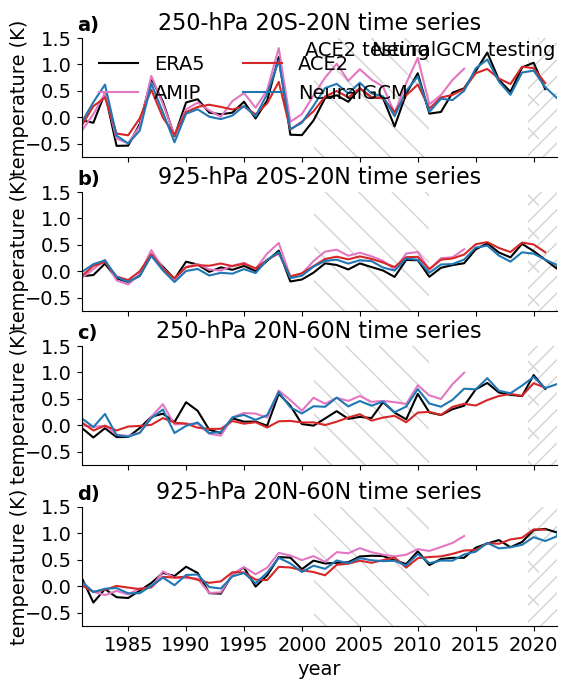

In [52]:
fig = plt.figure(figsize=(4.75,  7))#, layout = 'constrained')
plt.axis('off')

ax = fig.add_axes([0,0.67,1,0.17])
ax.plot(era5_norm_other.year[:-1], era5_norm_other.t[:-1], color = 'k', label = 'ERA5')
ax.plot(amip_norm_other.year, amip_norm_other.mean('variable'), color = '#E377C2', label = 'AMIP')
ax.plot(ace2_norm_other.year, ace2_norm_other.mean('member_id'), color = '#D62728', label = 'ACE2')
ax.plot(ngcm_norm_other.year, ngcm_norm_other.mean('variable'), color = '#1F77B4', label = 'NeuralGCM')

plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')
ax.text(2011,1.45, 'ACE2 testing', ha = 'right', va = 'top', fontsize = font)
ax.text(2021.9,1.45, 'NeuralGCM testing', ha = 'right', va = 'top', fontsize = font)


ax.set_xlim([1981,2022])
ax.set_xticks([1985,1990,1995,2000,2005,2010,2015,2020])
ax.set_xticklabels([])
ax.set_ylim([-0.75,1.5])
ax.set_yticks([-0.5,0,0.5,1.0,1.5])
ax.set_title(f'250-hPa {title_other} time series', fontsize = font+2)
ax.set_ylabel('temperature (K)',fontsize=font, labelpad= -3)
ax.tick_params(axis = 'both', labelsize = font)
plt.legend(bbox_to_anchor = None, loc = 'upper left', frameon=False, ncol = 2, fontsize = font)

ax = fig.add_axes([0,0.45,1,0.17])
ax.plot(era5_norm_900_other.year[:-1], era5_norm_900_other.t[:-1], color = 'k', label = 'ERA5')
ax.plot(amip_norm_900_other.year, amip_norm_900_other, color = '#E377C2', label = 'AMIP')
ax.plot(ace2_norm_900_other.year, ace2_norm_900_other, color = '#D62728', label = 'ACE2')
ax.plot(ngcm_norm_900_other.year, ngcm_norm_900_other, color = '#1F77B4', label = 'NeuralGCM')

plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')

ax.set_xlim([1981,2022])
ax.set_xticks([1985,1990,1995,2000,2005,2010,2015,2020])
ax.set_xticklabels([])
ax.set_ylim([-0.75,1.5])
ax.set_yticks([-0.5,0,0.5,1.0,1.5])
ax.set_title(f'925-hPa {title_other} time series', fontsize = font+2)
#ax.set_xlabel('year',fontsize=font)
ax.set_ylabel('temperature (K)',fontsize=font, labelpad= -3)
ax.tick_params(axis = 'both', labelsize = font)


ax = fig.add_axes([0,0.23,1,0.17])
ax.plot(era5_norm.year[:-1], era5_norm.t[:-1], color = 'k', label = 'ERA5')
ax.plot(amip_norm.year, amip_norm.mean('variable'), color = '#E377C2', label = 'AMIP')
ax.plot(ace2_norm.year, ace2_norm.mean('member_id'), color = '#D62728', label = 'ACE2')
ax.plot(ngcm_norm.year, ngcm_norm.mean('variable'), color = '#1F77B4', label = 'NeuralGCM')

plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')
# ax.text(2011,1.45, 'ACE2 testing', ha = 'right', va = 'top', fontsize = font)
# ax.text(2021.9,1.45, 'NeuralGCM testing', ha = 'right', va = 'top', fontsize = font)


ax.set_xlim([1981,2022])
ax.set_xticks([1985,1990,1995,2000,2005,2010,2015,2020])
ax.set_xticklabels([])
ax.set_ylim([-0.75,1.5])
ax.set_yticks([-0.5,0,0.5,1.0,1.5])
ax.set_title(f'250-hPa {title} time series', fontsize = font+2)
ax.set_ylabel('temperature (K)',fontsize=font, labelpad= -3)
ax.tick_params(axis = 'both', labelsize = font)
#plt.legend(bbox_to_anchor = None, loc = 'upper left', frameon=False, ncol = 2, fontsize = font)

ax = fig.add_axes([0,0,1,0.17])
ax.plot(era5_norm_900.year[:-1], era5_norm_900.t[:-1], color = 'k', label = 'ERA5')
ax.plot(amip_norm_900.year, amip_norm_900, color = '#E377C2', label = 'AMIP')
ax.plot(ace2_norm_900.year, ace2_norm_900, color = '#D62728', label = 'ACE2')
ax.plot(ngcm_norm_900.year, ngcm_norm_900, color = '#1F77B4', label = 'NeuralGCM')

plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
plt.axvspan(2020-0.5,2024, facecolor = 'none', hatch = '//')

ax.set_xlim([1981,2022])
ax.set_xticks([1985,1990,1995,2000,2005,2010,2015,2020])
ax.set_ylim([-0.75,1.5])
ax.set_yticks([-0.5,0,0.5,1.0,1.5])
ax.set_title(f'925-hPa {title} time series', fontsize = font+2)
ax.set_xlabel('year',fontsize=font)
ax.set_ylabel('temperature (K)',fontsize=font, labelpad= -3)
ax.tick_params(axis = 'both', labelsize = font)

fig.text(-0.01,0.85, 'a)', weight = 'bold', fontsize = font)
fig.text(-0.01,0.63, 'b)', weight = 'bold', fontsize = font)
fig.text(-0.01,0.41, 'c)', weight = 'bold', fontsize = font)
fig.text(-0.01,0.18, 'd)', weight = 'bold', fontsize = font)

plt.savefig('SI_Fig_time_series_'+title_other+'_and_'+title+'.pdf', dpi = 425, bbox_inches='tight')
plt.savefig('SI_Fig_time_series_'+title_other+'_and_'+title+'.eps', dpi = 425, bbox_inches='tight')

In [53]:
# Select any pressure level for spatial maps
level_p = 925

era5_900 = era5.sel(level = level_p)

amip_900 = amip.sel(plev = level_p*100)

ace2_900 = ace2.sel(level = level_p)

ngcm_900 = ngcm.sel(level = level_p)

In [54]:
# Calculate global trend
era5_900_year = era5_900.t.sel(year=slice(year1,year2))
era5_900_trend = linregress(era5_900_year,era5_900_year.year).slope*10

In [55]:
amip_900_year = amip_900.to_dataarray().mean('variable').sel(year=slice(year1,year2))
amip_900_trend = linregress(amip_900_year,amip_900_year.year).slope*10

In [56]:
ace2_900_year = ace2_900.mean('member_id').sel(year=slice(year1,year2))
ace2_900_trend = linregress(ace2_900_year, ace2_900_year.year).slope*10

In [57]:
ngcm_900_year = ngcm_900.to_dataarray().mean('variable').sel(year=slice(year1,year2))
ngcm_900_trend = linregress(ngcm_900_year,ngcm_900_year.year).slope*10

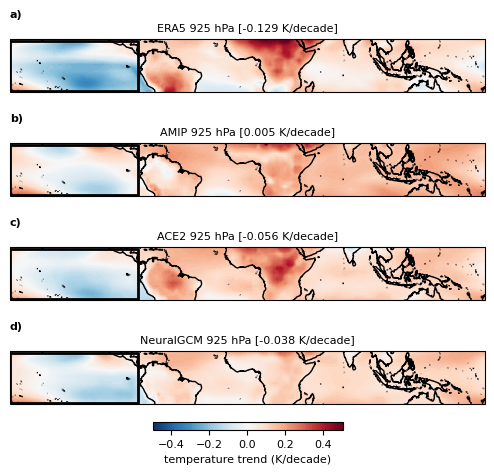

In [58]:
fig = plt.figure(figsize = (4.75,4))
plt.axis('off')

levels = np.arange(-0.5,0.51,0.01)
fontsize = 8
plt.rc('font', size=fontsize)

# a ERA5 925 trend
ax = fig.add_axes([0,0.78,1,0.2], projection=ccrs.PlateCarree())

data, lons = add_cyclic_point(era5_900_trend.T,era5_900_trend.longitude)

plot = plt.contourf(lons,era5_900_trend.latitude,data, cmap='RdBu_r', levels = levels)
ax.coastlines()
ax.set_extent([-180,180,-20,20], crs = ccrs.PlateCarree())
era5_global = get_ep(era5_900_trend)
ax.set_title(f'ERA5 {level_p} hPa [{era5_global:.3f} K/decade]', fontsize = fontsize)
draw_boxes(-180,right_side,-19,19)


# b AMIP 925 trend
ax = fig.add_axes([0,0.52,1,0.2], projection=ccrs.PlateCarree())

data, lons = add_cyclic_point(amip_900_trend,amip_900_trend.longitude)

plot = plt.contourf(lons,amip_900_trend.latitude,data, cmap='RdBu_r', levels = levels)
ax.coastlines()
ax.set_extent([-180,180,-20,20], crs = ccrs.PlateCarree())
amip_global = get_ep(amip_900_trend)
ax.set_title(f'AMIP {level_p} hPa [{amip_global:.3f} K/decade]', fontsize = fontsize)
draw_boxes(-180,right_side,-19,19)

# c ACE2 925 trend
ax = fig.add_axes([0,0.26,1,0.2], projection=ccrs.PlateCarree())

ace2_900_trend[:,0] = ace2_900_trend[:,-1] 
datas, lons = add_cyclic_point(ace2_900_trend,ace2_900_trend.longitude)

plot = plt.contourf(lons,ace2_900_trend.latitude, datas, cmap='RdBu_r', levels = levels)
ax.coastlines()
ax.set_extent([-180,180,-20,20], crs = ccrs.PlateCarree())
ace2_global = get_ep(ace2_900_trend)
ax.set_title(f'ACE2 {level_p} hPa [{ace2_global:.3f} K/decade]', fontsize = fontsize)
draw_boxes(-180,right_side,-19,19)

# d NGCM 925 trend 
ax = fig.add_axes([0,0,1,0.2], projection=ccrs.PlateCarree())

data, lons = add_cyclic_point(ngcm_900_trend.T,ngcm_900_trend.longitude)

plot = plt.contourf(lons,ngcm_900_trend.latitude,data, cmap='RdBu_r', levels = levels)
ax.coastlines()
ax.set_extent([-180,180,-20,20], crs = ccrs.PlateCarree())
ngcm_global = get_ep(ngcm_900_trend)
ax.set_title(f'NeuralGCM {level_p} hPa [{ngcm_global:.3f} K/decade]', fontsize = fontsize)
draw_boxes(-180,right_side,-19,19)

# Colorbar 
cb_ax = fig.add_axes([0.3,-0.03,0.4,0.02])
cbar = fig.colorbar(plot, ax=ax, ticks = levels, orientation = 'horizontal', cax = cb_ax)
cbar.set_ticks([-0.4,-0.2,0,0.2,0.4])
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label('temperature trend (K/decade)', size=fontsize)

fig.text(0,1, 'a)', weight = 'bold', fontsize = fontsize)
fig.text(0,0.74, 'b)', weight = 'bold', fontsize = fontsize)
fig.text(0,0.48, 'c)', weight = 'bold', fontsize = fontsize)
fig.text(0,0.22, 'd)', weight = 'bold', fontsize = fontsize)

plt.savefig(f'SI_fig_{level_p}hPa_trend_maps.eps', dpi = 600, bbox_inches='tight')
plt.savefig(f'SI_fig_{level_p}hPa_trend_maps.png', dpi = 600, bbox_inches='tight');

In [59]:
# Calculate time series 

# ERA5
era5_time_900 = area_weighted_ave(era5_900.sel(latitude = slice(lat1,lat2)))
era5_norm_900 = era5_time_900 - (era5_time_900.sel(year=slice(1980,1990)).mean().t)

# AMIP
amip_1_900 = amip_900.to_dataarray().mean('variable').sel(latitude = slice(lat1,lat2))
amip_time_900 = area_weighted_ave(amip_1_900)
amip_norm_900 = amip_time_900-(amip_time_900.sel(year=slice(1980,1990)).mean())

# ACE2
ace2_time_900 = area_weighted_ave(ace2_900.mean('member_id').sel(latitude = slice(lat1,lat2))).sel(year=slice(1979,2021))
ace2_norm_900 = ace2_time_900-(ace2_time_900.sel(year=slice(1980,1990)).mean())

# NGCM
ngcm_time_900 = area_weighted_ave(ngcm_900.to_dataarray().mean('variable').sel(latitude = slice(lat1,lat2)))
ngcm_norm_900 = ngcm_time_900-(ngcm_time_900.sel(year=slice(1980,1990)).mean())

In [60]:
ace2_direct = xr.open_dataset('/project/tas1/ockham/data1/Katy_temp_folder/ACE2_37/ace2_37_t850_1980_2022_128x64.nc')
ace2_direct['latitude'] = era5['latitude']
ace2_direct['longitude'] = era5['longitude']
ace2_direct = ace2_direct.squeeze().compute()
ace2_interp = ace2.sel(level=850)
era5_850 = era5.t.sel(level=850)

In [61]:
ace2_time_direct = area_weighted_ave(ace2_direct.TMP850).sel(year=slice(1981,2021))
ace2_norm_direct = ace2_time_direct-(ace2_time_direct.sel(year=slice(1981,1990)).mean())

ace2_time_interp = area_weighted_ave(ace2_interp).sel(year=slice(1981,2021))
ace2_norm_interp = ace2_time_interp-(ace2_time_interp.sel(year=slice(1981,1990)).mean())

era5_850_time = area_weighted_ave(era5_850).sel(year=slice(1981,2021))
era5_850_norm = era5_850_time-(era5_850_time.sel(year=slice(1981,1990)).mean())

KeyError: "'year' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'time': 517, 'member_id': 37})"

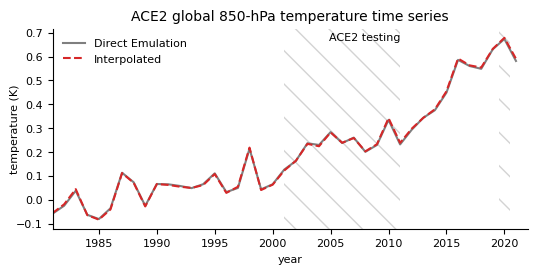

In [ ]:
fig = plt.figure(figsize = (4.75,2))

ax = fig.add_axes([0,0,1,1])
ax.plot(ace2_norm_direct.year, ace2_norm_direct.mean('member_id'), color = "#7F7F7F", label = 'Direct Emulation')
ax.plot(ace2_norm_interp.year, ace2_norm_interp.mean('member_id'), color = '#D62728', label = 'Interpolated', linestyle = '--')


plt.axvspan(2001, 2011, facecolor='none', hatch = "\\")
plt.axvspan(2020-0.5, 2020+0.5, facecolor='none', hatch = '\\')
ax.text(2011,0.7, 'ACE2 testing', ha = 'right', va = 'top', fontsize = font)



ax.set_xlim([1981,2022])
ax.set_title(f'ACE2 global 850-hPa temperature time series', fontsize = font+2)
ax.set_xlabel('year',fontsize=font)
ax.set_ylabel('temperature (K)',fontsize=font, labelpad= -3)
ax.tick_params(axis = 'both', labelsize = font)
plt.legend(bbox_to_anchor = None, loc = 'upper left', frameon=False, fontsize = font)

plt.savefig('ACE2_t850_direct_vs_interp.png', dpi = 600, bbox_inches='tight')
plt.savefig('ACE2_t850_direct_vs_interp.eps', dpi = 600, bbox_inches='tight')